In [2]:
import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression, make_classification
from joblib import Parallel, delayed

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from tqdm import tqdm

from pymoo.algorithms.soo.nonconvex.brkga import BRKGA
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize


In [5]:
# Generate a binary classification dataset with independent features and a target
X, y = make_classification(n_samples=10000, n_features=10, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, random_state=0, shuffle=False)
print(X.shape, y.shape)
corr = spearmanr(X).correlation
print(corr.shape)

# split [:,:5] into party 1 and split [:,5:] into party 2
corr1 = corr[:5, :5]
corr2 = corr[5:, 5:]

# calculate the determinant of each correlation matrix
det1 = np.linalg.det(corr1)
det2 = np.linalg.det(corr2)
det = np.linalg.det(corr)
print(f"det1: {det1:.2f}, det2: {det2:.2f}, det: {det:.2f}")

(10000, 10) (10000,)
(10, 10)
det1: 0.77, det2: 0.86, det: 0.32


In [26]:
# Generate a binary classification dataset with correlated features and a target
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
                           n_repeated=0, n_classes=2, random_state=None, shuffle=False)
print(X.shape, y.shape)
corr = spearmanr(X).correlation
print(corr.shape)

informative_feature_ids = np.arange(10)[:5]
repeat_feature_ids = np.arange(10)[5:]
for n_info in range(6):
    info_ids_1 = informative_feature_ids[:n_info]
    repeat_ids_1 = repeat_feature_ids[n_info:]
    ids_1 = np.concatenate([info_ids_1, repeat_ids_1])
    info_ids_2 = informative_feature_ids[n_info:]
    repeat_ids_2 = repeat_feature_ids[:n_info]
    ids_2 = np.concatenate([info_ids_2, repeat_ids_2])

    # print(f"n_info: {n_info}, ids_1: {ids_1}, ids_2: {ids_2}")
    corr1 = corr[ids_1, :][:, ids_1]
    corr2 = corr[ids_2, :][:, ids_2]
    corr_12 = corr[ids_1, :][:, ids_2]
    corr_sorted = corr[np.concatenate([ids_1, ids_2]), :][:, np.concatenate([ids_1, ids_2])]

    # calculate the determinant of each correlation matrix
    det1 = np.linalg.det(corr1)
    det2 = np.linalg.det(corr2)
    det12 = np.linalg.det(corr_12)
    det = np.linalg.det(corr_sorted)
    print(f"n_info: {n_info}, det1: {det1:.2f}, det2: {det2:.2f}, det12: {det12:.2f}, det: {det:.2f}")


(10000, 10) (10000,)
(10, 10)
n_info: 0, det1: 0.01, det2: 0.40, det12: 0.01, det: 0.00
n_info: 1, det1: 0.02, det2: 0.08, det12: 0.01, det: 0.00
n_info: 2, det1: 0.02, det2: 0.01, det12: -0.00, det: 0.00
n_info: 3, det1: 0.03, det2: 0.05, det12: -0.02, det: 0.00
n_info: 4, det1: 0.06, det2: 0.03, det12: 0.02, det: 0.00
n_info: 5, det1: 0.40, det2: 0.01, det12: 0.01, det: 0.00


1.0
0.0
0.9999999999999997
0.0
n_X1: 0, mcor1: 0.3432, mcor2: 0.4104, mcor12: 0.00931346
n_X1: 1, mcor1: 0.2913, mcor2: 0.3835, mcor12: 0.14597132
n_X1: 2, mcor1: 0.2696, mcor2: 0.3801, mcor12: 0.14960869
n_X1: 3, mcor1: 0.2621, mcor2: 0.3548, mcor12: 0.15305276
n_X1: 4, mcor1: 0.2145, mcor2: 0.3255, mcor12: 0.16779649
n_X1: 5, mcor1: 0.2256, mcor2: 0.2856, mcor12: 0.17861395
n_X1: 6, mcor1: 0.2370, mcor2: 0.2109, mcor12: 0.19782538
n_X1: 7, mcor1: 0.2533, mcor2: 0.2513, mcor12: 0.19905091
n_X1: 8, mcor1: 0.3078, mcor2: 0.2661, mcor12: 0.19403977
n_X1: 9, mcor1: 0.3797, mcor2: 0.2895, mcor12: 0.15088469
n_X1: 10, mcor1: 0.4104, mcor2: 0.3432, mcor12: 0.00931346


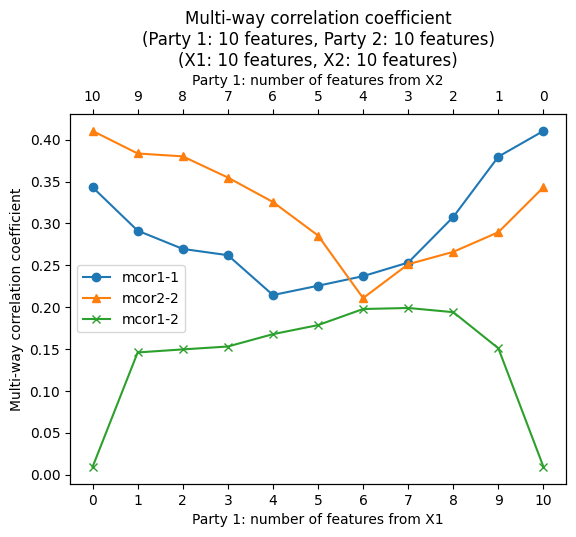

In [66]:
def mcor(corr):
    """Summarize the correlation matrix corr"""
    assert corr.shape[0] == corr.shape[1]
    d = corr.shape[0]
    eigen_values = np.linalg.eigvals(corr)
    score = 1 / np.sqrt(d) * np.sqrt((1 / (d - 1)) * np.sum((eigen_values - np.average(eigen_values)) ** 2))
    return score

def mcor_singular(corr):
    """Summarize the correlation matrix corr"""
    d = corr.shape[0]
    singular_values = np.linalg.svd(corr)[1]
    assert (singular_values > 0).any()
    score = 1 / np.sqrt(d) * np.sqrt((1 / (d - 1)) * np.sum((singular_values - np.average(singular_values)) ** 2))
    return score

print(mcor(np.ones((10, 10))))
print(mcor(np.eye(10)))
print(mcor_singular(np.ones((10, 10))))
print(mcor_singular(np.eye(10)))



# Generate two binary classification datasets with correlated features and a target
n_infomative = 6
n_features1 = 10
n_features2 = 10
# n_infomative = 3
# n_features1 = 5
# n_features2 = 5
assert n_features1 <= n_features2
n_features_on_party = [n_features1, n_features2]
n_features = n_features1 + n_features2
X1, y1 = make_classification(n_samples=10000, n_features=n_features1, n_informative=n_infomative,
                             n_redundant=n_features1 - n_infomative,
                             n_repeated=0, n_classes=2, random_state=0, shuffle=True)
X2, y2 = make_classification(n_samples=10000, n_features=n_features2, n_informative=n_infomative,
                             n_redundant=n_features2 - n_infomative,
                             n_repeated=0, n_classes=2, random_state=1, shuffle=True)
X = np.concatenate([X1, X2], axis=1)
corr = spearmanr(X).correlation

n_features = n_features1 + n_features2
X1_ids = np.arange(n_features)[:n_features1]
X2_ids = np.arange(n_features)[n_features1:]
n_X1s = np.arange(n_features1 + 1)
mcor1s = []
mcor2s = []
mcor12s = []
for n_X1 in n_X1s:
    assert n_X1 <= n_features1
    X1_ids_1 = X1_ids[:n_X1]
    X2_ids_1 = X2_ids[:n_features1-n_X1]
    ids_1 = np.concatenate([X1_ids_1, X2_ids_1])
    X1_ids_2 = X1_ids[n_X1:]
    X2_ids_2 = X2_ids[n_features1-n_X1:]
    ids_2 = np.concatenate([X1_ids_2, X2_ids_2])
    # print(f"n_X1: {n_X1}, ids_1: {ids_1}, ids_2: {ids_2}")

    corr1 = corr[ids_1, :][:, ids_1]
    corr2 = corr[ids_2, :][:, ids_2]
    corr_12 = corr[ids_1, :][:, ids_2]
    # print(np.linalg.det(corr_12.T @ corr_12))
    # print(corr_12.T @ corr_12)
    # initialize a new correlation matrix with an identity matrix
    corr_masked = np.zeros(corr.shape)
    # print(ids_1)
    # print(ids_2)
    # print(corr[ids_1, ids_2])

    # replace corr_masked[ids_1, :][:, ids_2] with corr[ids_1, :][:, ids_2]
    # and corr_masked[ids_2, :][:, ids_1] with corr[ids_2, :][:, ids_1]
    corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]
    corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]
    corr_sorted = corr[np.concatenate([ids_1, ids_2]), :][:, np.concatenate([ids_1, ids_2])]

    # print(corr_masked)

    # calculate the determinant of each correlation matrix
    # det1 = np.linalg.det(corr1)
    # det2 = np.linalg.det(corr2)
    # det12 = np.linalg.det(corr_12)
    # det_masked = np.linalg.det(corr_masked)
    # det = np.linalg.det(corr_sorted)
    # print(f"n_X1: {n_X1}, det1: {det1:.4f}, det2: {det2:.4f}, det12: {det12:.8f}, det_masked: {det_masked:.8f}, det: {det:.8f}")

    mcor = mcor_singular
    mcor1 = mcor(corr1)
    mcor2 = mcor(corr2)
    mcor12 = mcor(corr_12)
    print(f"n_X1: {n_X1}, mcor1: {mcor1:.4f}, mcor2: {mcor2:.4f}, mcor12: {mcor12:.8f}")
    mcor1s.append(mcor1)
    mcor2s.append(mcor2)
    mcor12s.append(mcor12)

# plot the trend of mcor1, mcor2, and mcor12 w.r.t. n_X1
ax = plt.gca()
plt.xlabel("Party 1: number of features from X1")
plt.ylabel("Multi-way correlation coefficient")
ax.plot(n_X1s, mcor1s, label="mcor1-1", marker="o")
ax.plot(n_X1s, mcor2s, label="mcor2-2", marker="^")
ax.plot(n_X1s, mcor12s, label="mcor1-2", marker="x")
# add an x-axis to show the number of informative features from X2

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax.set_xticks(n_X1s)
ax.set_xticklabels(n_X1s)
ax2.set_xticks(n_X1s)
ax2.set_xticklabels(n_features1 - n_X1s)
ax2.set_xlabel("Party 1: number of features from X2")

plt.title(f"Multi-way correlation coefficient\n(Party 1: {n_features1} features, Party 2: {n_features2} features)\n(X1: {n_features1} features, X2: {n_features2} features)")

ax.legend()
plt.show()



X1 and X2 are entirely split into two parties in both ends, thus the inter-party correlation mcor1-2 is 0 and the inner party correlation mcor1-1 and mcor2-2 are very large.

In [3]:
"""Function to calculate the mean of mcor inside all parties"""
def mean_mcor(corr, n_features_on_party):
    """
    Calculate the mean of mcor inside all parties
    :param corr: global correlation matrix of all parties
    :param n_features_on_party: List. Number of features on each party. The sum should equal to the size of corr.
    :return: (float) mean of mcor.
    """
    n_parties = len(n_features_on_party)
    assert sum(n_features_on_party) == corr.shape[0]
    corr_cut_points = np.cumsum(n_features_on_party)
    corr_cut_points = np.insert(corr_cut_points, 0, 0)
    mcors = []
    for i in range(n_parties):
        start = corr_cut_points[i]
        end = corr_cut_points[i+1]
        corr_party_i = corr[start:end, start:end]
        mcor_party_i = mcor_singular(corr_party_i)
        mcors.append(mcor_party_i)
    return np.mean(mcors)


In [4]:
"""
Using the previously generated X1 and X2, search for the best split of features. (brute force)
"""

def best_perm(perms):
    best_mcor = 0
    best_perm = None
    for perm in tqdm(perms):
        corr_perm = corr[:, perm]
        mcor = mean_mcor(corr_perm, n_features_on_party)
        if mcor > best_mcor:
            best_mcor = mcor
            best_perm = perm
    return best_mcor, best_perm

# iterate over all possible permutations of corr columns in parallel
n_jobs = 50
perms = list(itertools.permutations(range(corr.shape[1])))
perms_per_job = [perms[i::n_jobs] for i in range(n_jobs)]
best_mcors, best_perms = zip(*Parallel(n_jobs=n_jobs)(delayed(best_perm)(perms_per_job[i]) for i in range(n_jobs)))
best_mcor = max(best_mcors)
best_perm = best_perms[np.argmax(best_mcors)]

print(f"Best mcor: {best_mcor:.4f}")
print(f"Best party 1: {np.sort(best_perm[:n_features1])}")
print(f"Best party 2: {np.sort(best_perm[n_features1:])}")

 98%|█████████▊| 71367/72576 [00:16<00:00, 7748.58it/s]

Best mcor: 0.5734
Best party 1: [0 1 2 3 4]
Best party 2: [5 6 7 8 9]


100%|██████████| 72576/72576 [00:16<00:00, 4342.84it/s]


In [11]:
"""
Using the previously generated X1 and X2, search for the best split of features. (Heuristic, BRKGA)
"""

class DuplicationElimination(ElementwiseDuplicateElimination):
    def is_equal(self, a, b):
        return a.get("hash") == b.get("hash")


class CorrProblem(ElementwiseProblem):
    def __init__(self, corr, n_features_on_party):
        super().__init__(n_var=corr.shape[1], n_obj=1, n_constr=0, xl=-1, xu=1)
        self.corr = corr
        self.n_features_on_party = n_features_on_party

    def _evaluate(self, x, out, *args, **kwargs):
        order = np.argsort(x)
        corr_perm = self.corr[:, order]
        out['F'] = -mean_mcor(corr_perm, self.n_features_on_party)
        out['order'] = order
        out['hash'] = hash(tuple(order))


algorithm = BRKGA(
    n_elites=200,
    n_offsprings=700,
    n_mutants=100,
    bias=0.8,
    eliminate_duplicates=DuplicationElimination(),
)

start = time.time()
res = minimize(
    CorrProblem(corr, n_features_on_party),
    algorithm,
    ('n_gen', 10),
    seed=1,
    verbose=True,
)
end = time.time()
print(f"Time elapsed: {end - start:.2f} seconds")
permutation = res.opt.get('order')[0]
print(f"Best party 1: {np.sort(permutation[:n_features1])}")
print(f"Best party 2: {np.sort(permutation[n_features1:])}")
print(f"Best mean mcor: {-res.F}, random key: {res.X}")

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 | -3.035526E-01 | -3.980517E-01
     2 |     1800 | -3.211226E-01 | -3.980517E-01
     3 |     2600 | -3.333549E-01 | -3.980517E-01
     4 |     3400 | -3.410233E-01 | -4.009562E-01
     5 |     4200 | -3.494332E-01 | -4.009562E-01
     6 |     5000 | -3.568460E-01 | -4.100046E-01
     7 |     5800 | -3.620550E-01 | -4.100046E-01
     8 |     6600 | -3.674628E-01 | -4.128654E-01
     9 |     7400 | -3.713561E-01 | -4.128654E-01
    10 |     8200 | -3.757766E-01 | -4.184383E-01
Time elapsed: 3.80 seconds
Best party 1: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Best party 2: [10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29.]
Best mean mcor: [0.41843831], random key: [-0.61250488 -0.491009   -0.58732865 -0.66601065 -0.38487582 -0.63191715
 -0.45398233 -0.5272318  -0.83668181 -0.53904864  0.04837123  0.00564877
  0.62658769  0.85307365  0.53889823 -0.32159163  0.94452867  0.07353664
  0.12846391  0.262

Exactly the same mean mcor as the brute force search. The permutation is different, but the mean mcor is the same.

In [68]:
"""
Check if swapping features affect the mcor
"""
# Generate a binary classification dataset with correlated features and a target
X, y = make_regression(n_samples=10000, n_features=3, n_informative=0, random_state=None, shuffle=True)

n_trails = 100
singular_mcor_scores = []
eigen_mcor_scores = []
for i in range(n_trails):
    # random permute features
    perm = np.random.permutation(X.shape[1])
    # print(perm)
    X_perm = X[:, perm]
    # calculate mcor
    corr = spearmanr(X_perm).correlation
    singular_mcor_score = mcor_singular(corr)
    print(np.linalg.eig(corr)[0])
    print(np.std(np.linalg.eig(corr)[0]))
    eigen_mcor_score = mcor(corr)
    print(mcor(corr))

    singular_mcor_scores.append(singular_mcor_score)
    eigen_mcor_scores.append(eigen_mcor_score)

# print(singular_mcor_scores)
# see if the scores in the matrix are close enough
print(np.asarray(singular_mcor_scores).ptp())
print(np.asarray(eigen_mcor_scores).ptp())


[1.01676855 0.99829024 0.98494121]
0.013049579024923234
0.009227445820152759
[1.01676855 0.99829024 0.98494121]
0.013049579024922958
0.009227445820152766
[1.01676855 0.98494121 0.99829024]
0.013049579024922816
0.009227445820152726
[1.01676855 0.99829024 0.98494121]
0.013049579024922958
0.009227445820152766
[1.01676855 0.98494121 0.99829024]
0.013049579024922816
0.009227445820152726
[1.01676855 0.98494121 0.99829024]
0.013049579024922781
0.009227445820152686
[1.01676855 0.98494121 0.99829024]
0.013049579024922816
0.009227445820152726
[1.01676855 0.98494121 0.99829024]
0.013049579024922816
0.009227445820152726
[1.01676855 0.98494121 0.99829024]
0.013049579024922781
0.009227445820152686
[1.01676855 0.99829024 0.98494121]
0.013049579024923234
0.009227445820152759
[1.01676855 0.99829024 0.98494121]
0.013049579024922958
0.009227445820152766
[1.01676855 0.98494121 0.99829024]
0.013049579024922816
0.009227445820152726
[1.01676855 0.98494121 0.99829024]
0.013049579024922611
0.009227445820152877

array([1., 1.])

array([1., 1.])

n_cuts: 33: [ 0  3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69
 72 75 78 81 84 87 90 93 96 99]


100%|██████████| 100/100 [00:05<00:00, 16.74it/s]


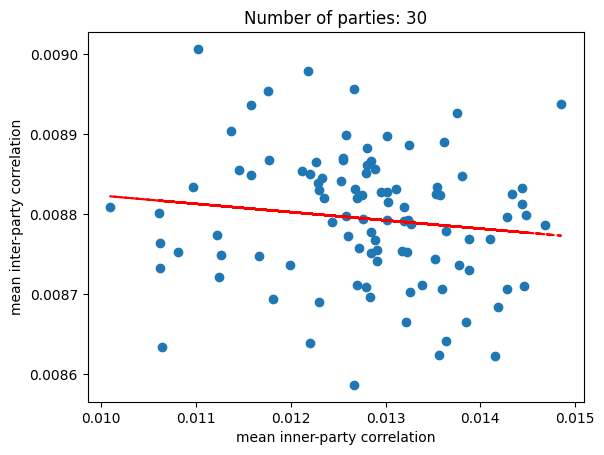

In [21]:
import os

from tqdm import tqdm

os.chdir("/home/zhaomin/code/VertiBench/src")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.datasets import make_regression

from preprocess.FeatureEvaluator import CorrelationEvaluator


# validate the conjecture that inner-party correlation is negatively correlated with inter-party correlation
mcor = CorrelationEvaluator.mcor_singular

# _corr_base = np.random.rand(10, 10)
# corr_mtx = np.tril(_corr_base) + np.tril(_corr_base, -1).T  # make it symmetric and iid
# # make the diagonal 1
# for i in range(corr_mtx.shape[0]):
#     corr_mtx[i, i] = 1
# print(corr_mtx)
np.random.seed(1)
X1 = make_regression(n_samples=10000, n_features=100, n_informative=100, random_state=None, shuffle=True)[0]
X2 = make_regression(n_samples=10000, n_features=100, n_informative=100, random_state=None, shuffle=True)[0]
X = np.concatenate((X1, X2), axis=1)
X = X1
corr_mtx = spearmanr(X).correlation

# random split the matrix into K parties
K = 30
n_features = corr_mtx.shape[0]
# col_cutoff = np.random.randint(1, n_features, size=K)     # cutoff points with duplicates
# col_cutoff = np.sort(col_cutoff)                          # sort cutoff points
# col_cutoff = np.append(col_cutoff, n_features)            # append the last index
# col_cutoff = np.insert(col_cutoff, 0, 0)                  # insert the first index
# col_cutoff = np.unique(col_cutoff)                        # remove duplicates
# n_cuts = len(col_cutoff) - 1                              # number of unique cuts

# split the features equally
n_features_on_party = n_features // K
col_cutoff = np.arange(0, n_features + 1, n_features_on_party)
n_cuts = len(col_cutoff) - 1

print(f"n_cuts: {n_cuts}: {col_cutoff}")

# try n_rounds times
n_rounds = 100
mean_diag_summary = []
mean_nondiag_summary = []
for t in tqdm(range(n_rounds)):
    perm = np.random.permutation(n_features)
    corr_perm = corr_mtx[:, perm][perm, :]
    # calculate the mcor for each cut feature set
    diag_mcor_list = []
    nondiag_mcor_list = []
    for i in range(n_cuts):
        for j in range(n_cuts):
            row_start = col_cutoff[i]
            row_end = col_cutoff[i+1]
            col_start = col_cutoff[j]
            col_end = col_cutoff[j+1]
            score = mcor(corr_perm[row_start:row_end, col_start:col_end])
            if i == j:
                diag_mcor_list.append(score)
            else:
                nondiag_mcor_list.append(score)
    mean_diag_mcor = np.mean(diag_mcor_list)
    mean_nondiag_mcor = np.mean(nondiag_mcor_list)
    mean_diag_summary.append(mean_diag_mcor)
    mean_nondiag_summary.append(mean_nondiag_mcor)

# spearman rank correlation between mean_diag_mcor and mean_nondiag_mcor
relation = spearmanr(mean_diag_summary, mean_nondiag_summary).correlation

# plot the results
plt.scatter(mean_diag_summary, mean_nondiag_summary)
# plot a regression line
z = np.polyfit(mean_diag_summary, mean_nondiag_summary, 1)
p = np.poly1d(z)
plt.plot(mean_diag_summary, p(mean_diag_summary), "r--")
plt.title(f"Number of parties: {K}")
plt.xlabel("mean inner-party correlation")
plt.ylabel("mean inter-party correlation")
plt.show()







Party correlation gamma=0 [-0.24885691241144126, -0.2395177745336422, -0.2080647678390014, -0.30339703136318125, -0.11115714991711784, -0.30654255325724167, -0.26952226635592763, -0.10380724651901885, -0.22904531788496596]
Party correlation gamma=1 []
Party correlation gamma=0 [-0.03722204076772573, -0.12663352071206257, -0.104109658845704, -0.2064915910984888, -0.06806690206365451, -0.14752166129188526, -0.1589549112912465, -0.043333566241777643, -0.08347966842343335]
Party correlation gamma=1 []
Party correlation gamma=0 [0.04776704762581507, -0.517509756312263, -0.2477440916236382, -0.11761895428240055, -0.1919448016831109, -0.1748715784933793, -0.14491097914373163, -0.1965343729000042, -0.03371532019676726]
Party correlation gamma=1 []
Party correlation gamma=0 [-0.6113151762387196, -0.629276860028268, -0.3726533420269472, -0.3565512679745805, -0.35170383323499654, -0.3328245051857791, -0.5596350483957074, -0.6887677101357957, -0.3117403370072266]
Party correlation gamma=1 []
Party

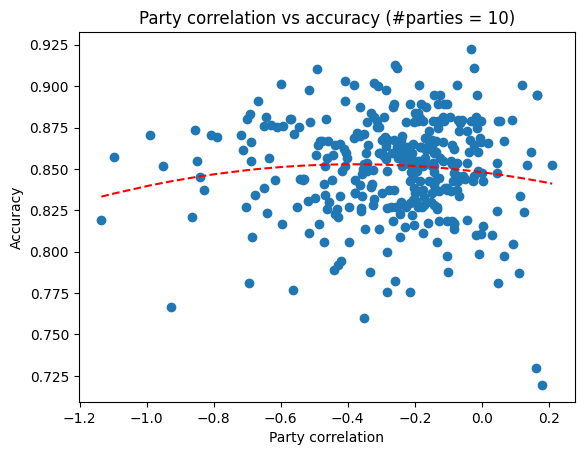

In [59]:
import matplotlib
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, load_svmlight_file
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBClassifier

from preprocess.FeatureSplitter import CorrelationSplitter, ImportanceSplitter
from preprocess.FeatureEvaluator import CorrelationEvaluator, ImportanceEvaluator


n_parties = 10
party_corr0_summary = []
party_corr1_summary = []
party_importance_summary = []
acc_summary = []
model = XGBClassifier(tree_method='hist', n_estimators=50, max_depth=5, learning_rate=0.1)
gamma = 1
for seed in range(40):
    X, y = make_classification(n_samples=10000, n_features=200, n_informative=10, n_redundant=0, n_repeated=190,
                               n_classes=2, random_state=seed, shuffle=True, class_sep=0.5)
    X = MinMaxScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # print(f"Combine accuracy: {accuracy_score(y_test, y_pred)}")

    # Random split into multiple parties
    splitter = ImportanceSplitter(num_parties=n_parties, weights=[10] + [50] * (n_parties - 1), seed=seed)
    Xs_train, Xs_test = splitter.split(X_train, X_test)

    # continue only when all the X has non-zero dimensions
    if not all([X.shape[1] > 0 for X in Xs_train]):
        continue

    # party_importance = imp_evaluator.evaluate(Xs_train)[1:] # exclude the primary party
    # print(f"Party importance {party_importance}")
    corr_evaluator0 = CorrelationEvaluator(gamma=0)
    corr_evaluator1 = CorrelationEvaluator(gamma=1)
    party_corr0 = []
    party_corr1 = []
    X_primary = Xs_train[0]
    for i in range(1, len(Xs_train)):
        corr = spearmanr(np.concatenate([X_primary, Xs_train[i]], axis=1)).correlation
        inter_corr = CorrelationEvaluator.mcor_singular(corr[X_primary.shape[1]:, :X_primary.shape[1]])
        inner_corr = CorrelationEvaluator.mcor_singular(corr[:X_primary.shape[1], :X_primary.shape[1]])
        inner_corr2 = CorrelationEvaluator.mcor_singular(corr[X_primary.shape[1]:, X_primary.shape[1]:])
        party_corr0.append((inter_corr - inner_corr + inter_corr - inner_corr2) / 2)
        # party_corr0.append(inter_corr * 2 - inner_corr - inner_corr2)
    print(f"Party correlation gamma=0 {party_corr0}")
    print(f"Party correlation gamma=1 {party_corr1}")

    # test training in each collaboration (between the primary party and each secondary party)
    model.fit(Xs_train[0], y_train)
    # y_pred = model.predict(Xs_test[0])
    # print(f"Primary party accuracy: {accuracy_score(y_test, y_pred):.4f}")
    acc_scores = []
    party_importance = []
    for i in range(1, len(Xs_train)):
        X_train_i = np.concatenate([Xs_train[0], Xs_train[i]], axis=1)
        X_test_i = np.concatenate([Xs_test[0], Xs_test[i]], axis=1)
        model.fit(X_train_i, y_train)
        y_pred = model.predict(X_test_i)
        acc = accuracy_score(y_test, y_pred)
        acc_scores.append(acc)

    party_corr0_summary.append(party_corr0)
    party_corr1_summary.append(party_corr1)
    party_importance_summary.append(party_importance)
    acc_summary.append(acc_scores)

party_corr0_summary = np.array(party_corr0_summary).flatten()
acc_summary = np.array(acc_summary).flatten()

corr_order = np.argsort(party_corr0_summary)
party_corr0_summary = party_corr0_summary[corr_order]
acc_summary = acc_summary[corr_order]

# postive_mask = party_corr0_summary > 2
# party_corr0_summary = party_corr0_summary[postive_mask]
# acc_summary = acc_summary[postive_mask]

# plot how party importance and correlation affects the accuracy in two separate line charts
plt.scatter(party_corr0_summary, acc_summary, marker='o')
# add a regression 2nd order polynomial
z = np.polyfit(party_corr0_summary, acc_summary, 2)
py = np.polyval(z, party_corr0_summary)
plt.plot(party_corr0_summary, py, "r--")
plt.xlabel("Party correlation")
plt.ylabel("Accuracy")
plt.title(f"Party correlation vs accuracy (#parties = {n_parties})")
plt.show()

In [35]:
977849 * 999883


977734591667